In [135]:
import pandas as pd
import numpy as np
import os
import json
import re
import matplotlib.pyplot as plt
import random
import time

import torch.nn as nn
import torch
from typing import List, Union

In [257]:
data_dir = './'
work_dir = './work'
exclude_z = True

train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
metadata = pd.read_csv(os.path.join(data_dir, 'supplemental_metadata.csv'))
with open(os.path.join(data_dir, 'character_to_prediction_index.json')) as f:
    c2e = json.load(f)

# this is our encoding
e2c = {v:k for k,v in c2e.items()}

def filter_cols(columns: list, pattern) -> list:
            return list(filter(lambda x: not re.search(pattern, x), columns))


hand_labels = ['x_left_hand_0', 'x_left_hand_1', 'x_left_hand_2', 'x_left_hand_3', 'x_left_hand_4', 'x_left_hand_5', 'x_left_hand_6', 'x_left_hand_7', 'x_left_hand_8', 'x_left_hand_9', 'x_left_hand_10', 'x_left_hand_11', 'x_left_hand_12', 'x_left_hand_13', 'x_left_hand_14', 'x_left_hand_15', 'x_left_hand_16', 'x_left_hand_17', 'x_left_hand_18', 'x_left_hand_19', 'x_left_hand_20', 'x_right_hand_0', 'x_right_hand_1', 'x_right_hand_2', 'x_right_hand_3', 'x_right_hand_4', 'x_right_hand_5', 'x_right_hand_6', 'x_right_hand_7', 'x_right_hand_8', 'x_right_hand_9', 'x_right_hand_10', 'x_right_hand_11', 'x_right_hand_12', 'x_right_hand_13', 'x_right_hand_14', 'x_right_hand_15', 'x_right_hand_16', 'x_right_hand_17', 'x_right_hand_18', 'x_right_hand_19', 'x_right_hand_20', 'y_left_hand_0', 'y_left_hand_1', 'y_left_hand_2', 'y_left_hand_3', 'y_left_hand_4', 'y_left_hand_5', 'y_left_hand_6', 'y_left_hand_7', 'y_left_hand_8', 'y_left_hand_9', 'y_left_hand_10', 'y_left_hand_11', 'y_left_hand_12', 'y_left_hand_13', 'y_left_hand_14', 'y_left_hand_15', 'y_left_hand_16', 'y_left_hand_17', 'y_left_hand_18', 'y_left_hand_19', 'y_left_hand_20', 'y_right_hand_0', 'y_right_hand_1', 'y_right_hand_2', 'y_right_hand_3', 'y_right_hand_4', 'y_right_hand_5', 'y_right_hand_6', 'y_right_hand_7', 'y_right_hand_8', 'y_right_hand_9', 'y_right_hand_10', 'y_right_hand_11', 'y_right_hand_12', 'y_right_hand_13', 'y_right_hand_14', 'y_right_hand_15', 'y_right_hand_16', 'y_right_hand_17', 'y_right_hand_18', 'y_right_hand_19', 'y_right_hand_20', 'z_left_hand_0', 'z_left_hand_1', 'z_left_hand_2', 'z_left_hand_3', 'z_left_hand_4', 'z_left_hand_5', 'z_left_hand_6', 'z_left_hand_7', 'z_left_hand_8', 'z_left_hand_9', 'z_left_hand_10', 'z_left_hand_11', 'z_left_hand_12', 'z_left_hand_13', 'z_left_hand_14', 'z_left_hand_15', 'z_left_hand_16', 'z_left_hand_17', 'z_left_hand_18', 'z_left_hand_19', 'z_left_hand_20', 'z_right_hand_0', 'z_right_hand_1', 'z_right_hand_2', 'z_right_hand_3', 'z_right_hand_4', 'z_right_hand_5', 'z_right_hand_6', 'z_right_hand_7', 'z_right_hand_8', 'z_right_hand_9', 'z_right_hand_10', 'z_right_hand_11', 'z_right_hand_12', 'z_right_hand_13', 'z_right_hand_14', 'z_right_hand_15', 'z_right_hand_16', 'z_right_hand_17', 'z_right_hand_18', 'z_right_hand_19', 'z_right_hand_20']

if exclude_z:
    hand_labels = filter_cols(hand_labels, 'z')

def encode(c):
    return c2e[c]
def decode(e):
    return e2c[e]

def load_sequence(file, seq_id):
    return pd.read_parquet(file, columns=hand_labels).loc[seq_id]

In [3]:
train

,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road
...,...,...,...,...,...
67203,train_landmarks/2118949241.parquet,2118949241,388192924,88,431-366-2913
67204,train_landmarks/2118949241.parquet,2118949241,388225542,154,994-392-3850
67205,train_landmarks/2118949241.parquet,2118949241,388232076,95,https://www.tianjiagenomes.com
67206,train_landmarks/2118949241.parquet,2118949241,388235284,36,90 kerwood circle


In [176]:
# select a random row from our example data
parquet = 'train_landmarks/1019715464.parquet'
rows = train[train.path == parquet]
random_row = rows.iloc[random.randint(0, len(rows))]
seq_id = random_row.sequence_id
test_seq = load_sequence(parquet, seq_id)
test_seq[test_seq.notna().any(axis=1)].dropna(axis=1)

,x_right_hand_0,x_right_hand_1,x_right_hand_2,x_right_hand_3,x_right_hand_4,x_right_hand_5,x_right_hand_6,x_right_hand_7,x_right_hand_8,x_right_hand_9,...,y_right_hand_11,y_right_hand_12,y_right_hand_13,y_right_hand_14,y_right_hand_15,y_right_hand_16,y_right_hand_17,y_right_hand_18,y_right_hand_19,y_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
1981815768,0.492210,0.510160,0.523481,0.522938,0.515781,0.551755,0.543291,0.524117,0.507514,0.539072,...,0.504349,0.498396,0.532664,0.525109,0.517807,0.513072,0.540500,0.533894,0.528176,0.525490
1981815768,0.537398,0.558732,0.574776,0.571066,0.560176,0.596788,0.581199,0.566203,0.555416,0.582908,...,0.508340,0.500395,0.550037,0.525743,0.514294,0.508916,0.551308,0.531262,0.521307,0.516022
1981815768,0.363114,0.480863,0.572976,0.634411,0.685255,0.556225,0.655530,0.722346,0.780071,0.502202,...,0.722479,0.759432,0.684785,0.692721,0.722344,0.753152,0.703291,0.702822,0.714754,0.730621
1981815768,0.340697,0.450055,0.529738,0.592612,0.645264,0.522263,0.634014,0.704793,0.758671,0.471570,...,0.776055,0.813012,0.720452,0.739886,0.777474,0.804738,0.747700,0.750844,0.759022,0.763541
1981815768,0.338704,0.463416,0.549891,0.621182,0.686056,0.516134,0.636893,0.704245,0.755567,0.458363,...,0.783118,0.822787,0.723426,0.740265,0.786643,0.823900,0.752218,0.755540,0.765447,0.775632
1981815768,0.322227,0.448481,0.543317,0.611441,0.658683,0.509096,0.633924,0.707757,0.757651,0.460813,...,0.796620,0.837721,0.728423,0.754838,0.801413,0.835587,0.757813,0.785493,0.809927,0.825269
1981815768,0.297995,0.445844,0.544910,0.618481,0.682888,0.498656,0.630847,0.703901,0.755986,0.447199,...,0.794115,0.834839,0.730565,0.757074,0.805049,0.841044,0.766146,0.782958,0.802995,0.819533
1981815768,0.255538,0.421312,0.525827,0.605501,0.675924,0.492546,0.632723,0.708560,0.759833,0.447891,...,0.792883,0.832307,0.733896,0.760124,0.809978,0.846821,0.770499,0.793182,0.815816,0.833440
1981815768,0.232102,0.415478,0.525814,0.606671,0.681870,0.492148,0.641327,0.712655,0.761968,0.444630,...,0.803614,0.844937,0.737608,0.767745,0.818349,0.856536,0.777834,0.793129,0.814469,0.833268


Training target: 3885 arbor manor way
null seqeunce length: 146


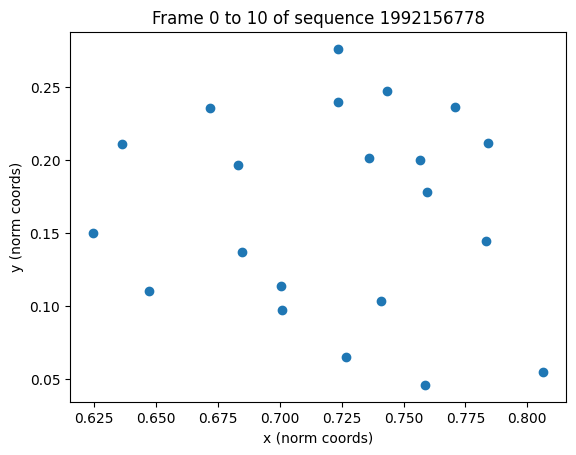

In [5]:
# doing some data exploration
print(f'Training target: {random_row.phrase}')
print('null seqeunce length:', test_seq.isna().all(axis=1).sum())

x_labels = filter_cols(test_seq.columns, '^x')
y_labels = filter_cols(test_seq.columns, '^y')
start_frame = 0
end_frame = 10
plt.scatter(test_seq[x_labels].iloc[start_frame:end_frame], test_seq[y_labels].iloc[start_frame:end_frame])
plt.xlabel('x (norm coords)')
plt.ylabel('y (norm coords)')
plt.title(f'Frame {start_frame} to {end_frame} of sequence {seq_id}')
plt.show()

In [6]:
# this just asserts that the left hand is also present in training data. We will want to train on both hands and thus should come up with a means of determining which hand is being used
table = pd.read_parquet('train_landmarks/1019715464.parquet', columns=hand_labels)
table[pd.isna(table.x_left_hand_0)].index.unique().size

992

Here we see that left and right hands are often mutually exclusive, but perhaps not always. We may consider creating an encoding for the hand in use to reduce the number of inputs to the nn model by a factor of 2.

After some reading, CTC loss seems to be the intuitive method to training a model that does these predictions. CTC loss defines a loss metric for situations in which one wishes to train a sequence to sequence loss when there is no direct mapping between elements in the input and elements in the output except for their temporal order.

In [56]:
import math
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [88]:
class ASLFFModel(nn.Module):
    """
    Basic feed forward model that we apply independently to each layer and then use CTC Loss to train alignments
    """
    def __init__(self):
        super().__init__()
        self.d_model = 84

        self.l1 = nn.Linear(84, 120)
        self.l2 = nn.Linear(120, 120)
        self.l3 = nn.Linear(120, 120)
        self.l4 = nn.Linear(120, len(c2e))
        self.relu = nn.ReLU()
        self.sm = nn.LogSoftmax(-1)

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        batch_dim, samples, d_model = z.size()
        assert d_model == 84 # TODO: will change this when model dimension is parameterized

        # being completely honest, I need to know more about what should be happening here. This is like the very basic image classification assignment
        data = self.l4(self.relu(self.l3(self.relu(self.l2(self.relu(self.l1(z)))))))
        log_probs = self.sm(data)

        return log_probs        

In [180]:
class ASLConvModel(nn.Module):
    """
    Apply a convolution around each sample so we have nearby context
    """
    def __init__(self, d_model=42, kernel_size=5, stride=5):
        super().__init__()
        self.d_model = d_model

        self.c1 = nn.Conv1d(self.d_model, 21, kernel_size, stride)
        self.relu = nn.ReLU()
        self.l1 = nn.Linear(21, 120)
        self.l2 = nn.Linear(120, 120)
        self.l3 = nn.Linear(120, len(c2e))
        self.sm = nn.LogSoftmax(-1)

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        batch_dim, samples, d_model = z.size()
        z = self.c1(z.transpose(1,2))
        z = z.transpose(1,2)
        z = self.l1(z)
        z = self.relu(z)
        z = self.l2(z)
        z = self.relu(z)
        z = self.l3(z)
        return self.sm(z)
        

In [59]:
class ASLTransformerModel(nn.Module):
    """
    Although intuition suggests that this task is achieved through non-squential architecture, I'm just trying this here to see if there is a better
    """
    def __init__(self, output_size):
        super().__init__()
        self.d_model = d_model
        self.output_size = output_size

        self.t = nn.Transformer(d_model=84, nhead=7, batch_first=True)
        self.pe = PositionalEncoding(d_model=84, dropout=0)

    def get_target_mask(self, size) -> torch.tensor:
        return self.t.generate_square_subsequent_mask(size)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        batch, seq_len, d_model = src.size()

        src = self.pe(src)
        tgt = self.pe(tgt)

        return self.t(src, tgt, src_mask, tgt_mask)

        # the output should be the log probs of the classes
        # (T, N, C) where C is the number of characters, t is the input length and n is the batch size

In [222]:
class ASLData(torch.utils.data.Dataset):
    """
    Fast, randomized ASL dataset that reads parquet files in the 'train_landmarks' folder of root_data_dir
    """
    def __init__(self, root_data_dir, input_length=150, output_length=None, exclude_z=True):
        super().__init__()
        self.train = pd.read_csv(os.path.join(root_data_dir, 'train.csv'))

        # create the list of files that we can parse
        self.root_data_dir = root_data_dir
        def parquet_match(x):
            match = re.match(r'(\d+)\.parquet', x)
            if match:
                return int(match.group(1))
        file_ids = set(map(parquet_match, os.listdir(os.path.join(root_data_dir, 'train_landmarks'))))

        self.train = self.train[self.train.file_id.isin(file_ids)]
        # shuffle dataset within file groups
        self.train = self.train.groupby('file_id').sample(frac=1).reset_index()
        
        def filter_cols(columns: list, pattern) -> list:
            return list(filter(lambda x: re.search(pattern, x), columns))

        # hardcode these for faster parquet retrieval. Otherwise we have to load the file to parse the header
        self.hand_labels = ['x_left_hand_0', 'x_left_hand_1', 'x_left_hand_2', 'x_left_hand_3', 'x_left_hand_4', 'x_left_hand_5', 'x_left_hand_6', 'x_left_hand_7', 'x_left_hand_8', 'x_left_hand_9', 'x_left_hand_10', 'x_left_hand_11', 'x_left_hand_12', 'x_left_hand_13', 'x_left_hand_14', 'x_left_hand_15', 'x_left_hand_16', 'x_left_hand_17', 'x_left_hand_18', 'x_left_hand_19', 'x_left_hand_20', 'x_right_hand_0', 'x_right_hand_1', 'x_right_hand_2', 'x_right_hand_3', 'x_right_hand_4', 'x_right_hand_5', 'x_right_hand_6', 'x_right_hand_7', 'x_right_hand_8', 'x_right_hand_9', 'x_right_hand_10', 'x_right_hand_11', 'x_right_hand_12', 'x_right_hand_13', 'x_right_hand_14', 'x_right_hand_15', 'x_right_hand_16', 'x_right_hand_17', 'x_right_hand_18', 'x_right_hand_19', 'x_right_hand_20', 'y_left_hand_0', 'y_left_hand_1', 'y_left_hand_2', 'y_left_hand_3', 'y_left_hand_4', 'y_left_hand_5', 'y_left_hand_6', 'y_left_hand_7', 'y_left_hand_8', 'y_left_hand_9', 'y_left_hand_10', 'y_left_hand_11', 'y_left_hand_12', 'y_left_hand_13', 'y_left_hand_14', 'y_left_hand_15', 'y_left_hand_16', 'y_left_hand_17', 'y_left_hand_18', 'y_left_hand_19', 'y_left_hand_20', 'y_right_hand_0', 'y_right_hand_1', 'y_right_hand_2', 'y_right_hand_3', 'y_right_hand_4', 'y_right_hand_5', 'y_right_hand_6', 'y_right_hand_7', 'y_right_hand_8', 'y_right_hand_9', 'y_right_hand_10', 'y_right_hand_11', 'y_right_hand_12', 'y_right_hand_13', 'y_right_hand_14', 'y_right_hand_15', 'y_right_hand_16', 'y_right_hand_17', 'y_right_hand_18', 'y_right_hand_19', 'y_right_hand_20', 'z_left_hand_0', 'z_left_hand_1', 'z_left_hand_2', 'z_left_hand_3', 'z_left_hand_4', 'z_left_hand_5', 'z_left_hand_6', 'z_left_hand_7', 'z_left_hand_8', 'z_left_hand_9', 'z_left_hand_10', 'z_left_hand_11', 'z_left_hand_12', 'z_left_hand_13', 'z_left_hand_14', 'z_left_hand_15', 'z_left_hand_16', 'z_left_hand_17', 'z_left_hand_18', 'z_left_hand_19', 'z_left_hand_20', 'z_right_hand_0', 'z_right_hand_1', 'z_right_hand_2', 'z_right_hand_3', 'z_right_hand_4', 'z_right_hand_5', 'z_right_hand_6', 'z_right_hand_7', 'z_right_hand_8', 'z_right_hand_9', 'z_right_hand_10', 'z_right_hand_11', 'z_right_hand_12', 'z_right_hand_13', 'z_right_hand_14', 'z_right_hand_15', 'z_right_hand_16', 'z_right_hand_17', 'z_right_hand_18', 'z_right_hand_19', 'z_right_hand_20']
        if exclude_z:
            self.hand_labels = filter_cols(hand_labels, '[xy]_')
        
        if output_length:
            self.max_output_len = output_length
        else:
            self.max_output_len = max(list(map(len, self.train.phrase)))
        self.input_length = input_length

        self.current_parquet = None
        self.current_file_id = None
            
    def __getitem__(self, idx):
        row = self.train.loc[idx]
    
        # just do a bit of table caching so we don't have to do redundant reads
        if row.file_id == self.current_file_id:
            parquet = self.current_parquet
        else:
            parquet_path = os.path.join(self.root_data_dir, row.path)
            parquet = pd.read_parquet(parquet_path, columns=self.hand_labels)
            self.current_parquet = parquet
            self.current_file_id  = row.file_id
            
        # we need to pad sequences and targets
        seq = parquet.loc[row.sequence_id].fillna(0)
        seq = torch.tensor(seq.to_numpy())
        
        label = torch.torch.tensor(list(map(encode, row.phrase)))
        
        seq_len = len(seq)
        label_len = len(label)
    
        # pad sequences and targets
        label = nn.functional.pad(label, (0, self.max_output_len - label_len))
        if seq_len > self.input_length:
            print(f'Warning: input length of {seq_len} processed. Truncating but you may want to extend the input dimension to acommodate this example')
            seq = seq[:self.input_length]
        else:
            seq = nn.functional.pad(seq, (0, 0, 0, self.input_length - seq_len))
            
        return seq, label, seq_len, label_len
    
    def __len__(self):
        return len(self.train) - 1

In [263]:
input_length = 1024
output_length = 80

dataset = ASLData('./', input_length=input_length)
# TODO: might try a sampler
dl = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=False)

## model training
n_epochs = 10
batch_size = 10

ctc_loss = nn.CTCLoss()
model = ASLConvModel(d_model=84)
optim = torch.optim.Adam(model.parameters())

model.train()

total_loss = 0
log_interval = 200
start_time = time.time()
num_batches = len(dl) // batch_size

for epoch in range(n_epochs):
    for batch, (seq, phrase, seq_len, phrase_len) in enumerate(dl):
        pred = model(seq).transpose(0,1)
        seq_len = torch.ones(len(phrase_len), dtype=int)*pred.size()[0]

        loss = ctc_loss(pred, phrase, seq_len, phrase_len)
        
        optim.zero_grad()
        loss.backward()
        optim.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                 f'ms/batch {ms_per_batch:5.2f} | '
                 f'loss {cur_loss:5.2f}')
            total_loss = 0
            start_time = time.time()


| epoch   0 |   200/   40 batches | ms/batch  5.07 | loss  9.46
| epoch   1 |   200/   40 batches | ms/batch  9.46 | loss  6.70
| epoch   2 |   200/   40 batches | ms/batch  9.62 | loss  6.68
| epoch   3 |   200/   40 batches | ms/batch  9.88 | loss  6.68
| epoch   4 |   200/   40 batches | ms/batch  9.56 | loss  6.68
| epoch   5 |   200/   40 batches | ms/batch  9.56 | loss  6.68
| epoch   6 |   200/   40 batches | ms/batch  9.55 | loss  6.68
| epoch   7 |   200/   40 batches | ms/batch  9.50 | loss  6.68
| epoch   8 |   200/   40 batches | ms/batch  9.47 | loss  6.68
| epoch   9 |   200/   40 batches | ms/batch  9.48 | loss  6.68


Some things to try: 
- parameter initialization
- the random shuffle is not random
- see what is going on with the network

The most curious thing is that the loss stops at around 6.6


In [264]:
model.eval()
seq, phrase, seq_len, phrase_len = dataset[0]
seq = seq[None, :, :]
out = model(seq).squeeze(0)
out_max = torch.argmax(out, dim=1)
list(map(lambda x: decode(int(x)), out_max))


[' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' '